详细版：手动生成数据，data_iter函数, 模型， loss， 优化算法等

In [1]:
import random
import torch
from d2l import torch as d2l

In [2]:
# 1. 生成噪声数据 y = Xw + b + noise
# input: w, b 后续需要去拟合；num_examples 数据数量
# return: X, y
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# generate data
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

# show
print('features:', features[0:2], '\nlabels:', labels[0:2])

features: tensor([[-0.8395, -0.2307],
        [-0.3172,  2.3915]]) 
labels: tensor([[ 3.3042],
        [-4.5526]])


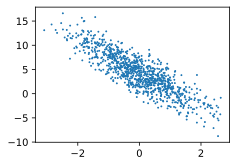

In [3]:
# show in figure
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
               labels.detach().numpy(), 1)

In [4]:
# 2. 定义data_iter的函数，每次调用时生成batch_size大小的数据
# input: features, labels, batch_size
# output: batch_size大小的 features, labels
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱index，起到随机效果
    random.shuffle(indices)
    # 进入循环，每次取batch_size
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        

# yield 用法
# ## 调用
# 一个带有 yield 的函数就是一个 generator，它和普通函数不同，生成一个 generator 
# 看起来像函数调用，但不会执行任何函数代码，直到对其调用 next()才开始执行
# （在 for 循环中会自动调用 next()）
# ## 函数内逻辑
# 每执行到一个 yield 语句就会中断，并返回一个迭代值，下次执行时从 yield 的下一个语句继续执行。

        
# test
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.4925,  0.6070],
        [ 0.9037, -1.3655],
        [ 1.5031, -0.8900],
        [ 1.8571,  0.4913],
        [ 0.0239,  1.4731],
        [ 0.4254,  0.1524],
        [ 0.7046, -1.5519],
        [-2.1422,  2.5537],
        [ 0.0610,  0.3495],
        [ 0.8018, -0.5236]]) 
 tensor([[ 7.1046],
        [10.6405],
        [10.2208],
        [ 6.2449],
        [-0.7669],
        [ 4.5386],
        [10.8875],
        [-8.7731],
        [ 3.1285],
        [ 7.5852]])


In [5]:
# 3. 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad=True)

In [6]:
# 4. 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w)+b

In [7]:
# 5. 定义损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

In [8]:
# 6. 定义优化算法
# loss是基于参数的函数，backward loss function。根据backward后计算的梯度，更新参数
# input: params / which parameter to update, learning rate, batch_size
def sgd(params, lr, batch_size):
    with torch.no_grad(): # 更新参数时不改变梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
        

In [9]:
# 7. 训练
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(10, features, labels):
        # 网络里跑一个backward & 计算loss
        l = loss(net(X, w, b), y)
        # loss backward 计算每个参数的梯度
        l.sum().backward()
        # 根据梯度 更新参数
        sgd([w, b], lr, batch_size)
    # 跑完一个epoch后，评估一下网络效果
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch = {epoch}, loss = {train_l.mean():f}')

epoch = 0, loss = 0.029572
epoch = 1, loss = 0.000109
epoch = 2, loss = 0.000054
